In [187]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using StaticArrays
using Plots

using Profile
using PProf
using ProfileSVG

import Base: show

In [194]:
meanv = priorvar(:mean, NormalMeanPrecision{Float64})
precv = priorvar(:precision, GammaAB{Float64})

gmpnode = GaussianMeanPrecisionNode(factorisation = SA[ SA[1], SA[2], SA[3] ])

connect!(gmpnode, :mean, meanv, 1)
connect!(gmpnode, :precision, precv, 1)

y = datavar(:y, Float64)

connect!(gmpnode, :value, y, 1)

activate!(gmpnode)

setbelief!(meanv, NormalMeanPrecision(0.0, 0.00001))
setbelief!(precv, GammaAB(0.1, 0.1))

In [195]:
realprecision = 0.01999
realmean = -200.0
n = 500
iters = 100

data = rand(Normal(realmean, sqrt(1.0 / realprecision)), (n, ));

In [196]:
currentmeanv = nothing
currentprecv = nothing

subscribe!(getbelief(meanv), (d) -> global currentmeanv = getdata(d))
subscribe!(getbelief(precv), (d) -> global currentprecv = getdata(d))

averageE = combineLatest(
    getbelief(meanv), getbelief(precv), getbelief(y), 
    strategy = PushNew()
) |> map(Float64, (beliefs) -> averageEnergy(NormalMeanPrecision, beliefs)) 

differentialE = combineLatest(
    getbelief(meanv), getbelief(precv), 
    strategy = PushNew()
) |> map(Float64, (beliefs) -> reduce(+, map(differentialEntropy, beliefs)))

fe = Matrix{Float64}(undef, n, iters)
ma = Vector{Float64}(undef, n)
pa = Vector{Float64}(undef, n)

for i in 1:n
    tmp1 = currentmeanv
    tmp2 = currentprecv
    
    update!(meanv, tmp1)
    update!(precv, tmp2)
      
    averageGamma = combineLatest(
        of(as_belief(tmp2.a)), of(as_belief(tmp2.b)), getbelief(precv),
        strategy = PushNew()
    ) |> map(Float64, (d) -> averageEnergy(GammaAB, d))
    
    averageNormal = combineLatest(
        of(as_belief(tmp1.mean)), of(as_belief(tmp1.precision)), getbelief(meanv),
        strategy = PushNew()
    ) |> map(Float64, (d) -> averageEnergy(NormalMeanPrecision, d))
    
    freeEnergy = combineLatest(
        averageE, averageGamma, averageNormal, differentialE,
        strategy = PushNew()
    ) |> map(Float64, (d) -> d[1] + d[2] + d[3] - d[4])

    for j in 1:iters
        subscription = subscribe!(freeEnergy, (d) -> fe[i, j] = d)
        update!(y, data[i])
        # update!(meanv, tmp1)
        # update!(precv, tmp2)
        unsubscribe!(subscription)
    end
    
    ma[i] = mean(currentmeanv)
    pa[i] = mean(currentprecv)
    
    # update!(meanv, currentmeanv)
    # update!(precv, currentprecv)
end

println("meanv ", mean(currentmeanv))
println("precv ", mean(currentprecv))

meanv -199.5034515207065
precv 0.01829667469143135


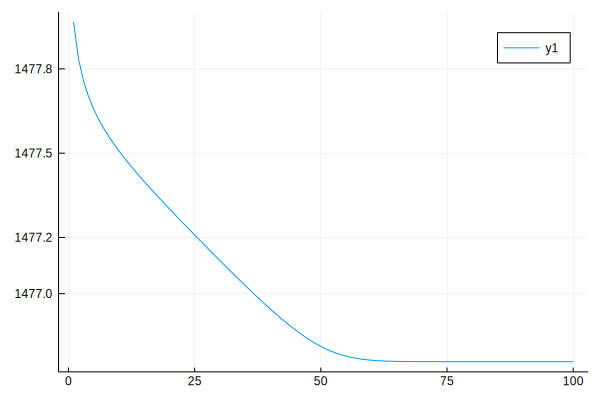

In [197]:
fevalues = vec(sum(fe, dims = 1))
plot(fevalues)

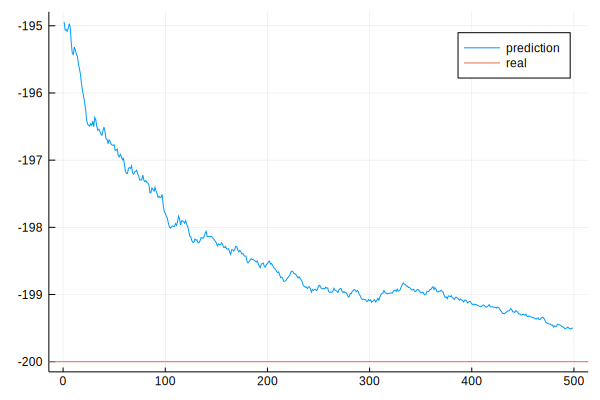

In [198]:
plot(ma[2:end], label = :prediction)
plot!([ realmean ], seriestype=:hline, label = :real)

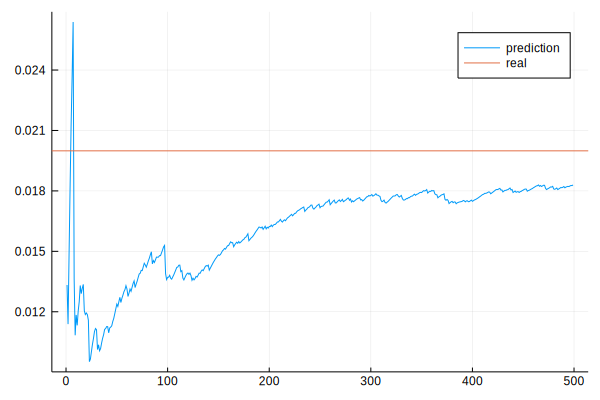

In [199]:
plot(pa[2:end], label = :prediction)
plot!([ realprecision ], seriestype=:hline, label = :real)

In [200]:
collect(zip(ma, pa))

500-element Array{Tuple{Float64,Float64},1}:
 (-194.77349762021063, 0.9997776955718514)
 (-194.9436493200125, 0.013329555437550494)
 (-195.0641881977793, 0.011386033215184976)
 (-195.05474039286364, 0.014870843422414463)
 (-195.08498443815304, 0.01815806041600696)
 (-195.04163308145496, 0.021235670753449756)
 (-194.96729347600177, 0.02365620272677215)
 (-195.02363279592134, 0.026384653810316357)
 (-195.25380976797422, 0.013639966581955702)
 (-195.40853165017433, 0.010832780846951382)
 (-195.4275948428685, 0.011840674852883561)
 (-195.31653402656872, 0.011324702403028294)
 (-195.35980081740334, 0.012043877569716241)
 ⋮
 (-199.47436717162932, 0.01815975058974357)
 (-199.48451700979535, 0.01818026012233103)
 (-199.48539384852953, 0.018217148114162713)
 (-199.5101122878543, 0.01815523490425518)
 (-199.50612609224038, 0.01818948143370611)
 (-199.49587346451173, 0.018209274954065897)
 (-199.48445284448562, 0.01822488913201254)
 (-199.5015238594984, 0.018214181711474434)
 (-199.50758488585936